In [3]:
!pip uninstall  -y  socceraction

Found existing installation: socceraction 0.2.0
Uninstalling socceraction-0.2.0:
  Successfully uninstalled socceraction-0.2.0


In [4]:
!pip install tables==3.6.1
!pip install socceraction
!pip install socceraction[statsbomb]

  Using cached tables-3.6.1.tar.gz (4.6 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.3/86.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.7 MB/s eta 0:00:00


In [5]:
!pip install fuzzywuzzy

In [6]:
import pandas as pd
from io import BytesIO
from datetime import timedelta
from datetime import datetime
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import graphviz
from six import StringIO
import pydotplus
from socceraction.spadl.wyscout import convert_to_spadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels
from socceraction.vaep.formula import value
from socceraction.data.statsbomb import StatsBombLoader
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [7]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [8]:
# Function that returns decoded Json files better than panda
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

In [9]:
# Reading the Coaches Data
coaches_json = read_json_file('/content/drive/MyDrive/thesis/data/coaches.json')
coaches = pd.read_json(coaches_json)

# Checking for Nulls
coaches.isna().sum()

wyId             0
shortName        0
firstName        0
middleName       0
lastName         0
birthDate        2
birthArea        0
passportArea     0
currentTeamId    0
dtype: int64

Birth day or age of a coach is not an important factor and even if it will be proved to be there is only two missing

In [10]:
# Visualizing the table to see how the data looks
coaches.head()

,wyId,shortName,firstName,middleName,lastName,birthDate,birthArea,passportArea,currentTeamId
0,275580,Cesar Domingo,César Domingo,,Mendiondo López,None,"{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...","{'id': 76, 'alpha2code': 'BR', 'alpha3code': '...",0
1,14710,J. Heynckes,Josef,,Heynckes,1945-05-09,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...",0
2,135480,G. De Biasi,Giovanni,,De Biasi,1956-06-16,"{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...","{'id': 380, 'alpha2code': 'IT', 'alpha3code': ...",0
3,210074,Marcelino,Marcelino,,García Toral,1965-08-14,"{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...","{'id': 724, 'alpha2code': 'ES', 'alpha3code': ...",674
4,293398,T. Korkut,Tayfun,,Korkut,1974-04-02,"{'id': 276, 'alpha2code': 'DE', 'alpha3code': ...","{'id': 792, 'alpha2code': 'TR', 'alpha3code': ...",0


In [11]:
# Reading the teams data
teams_json = read_json_file('/content/drive/MyDrive/thesis/data/teams.json')
teams = pd.read_json(teams_json)

# Checking for Nulls
teams.isna().sum()

city            0
name            0
wyId            0
officialName    0
area            0
type            0
dtype: int64

In [12]:
# Visualizing the table to see how the data looks
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


In [13]:
# Reading the players data
player_json = read_json_file('/content/drive/MyDrive/thesis/data/players.json')
players = pd.read_json(player_json)

# Checking for Nulls
players.isna().sum()

passportArea              0
weight                    0
firstName                 0
middleName                0
lastName                  0
currentTeamId            91
birthDate                 0
height                    0
role                      0
birthArea                 0
wyId                      0
foot                      0
shortName                 0
currentNationalTeamId     0
dtype: int64

With investigation it wa found these null values correspond to players that did not play that season and therefore have a ull team ID value and national team id as well

In [14]:
# Visualizing the table to see how the data looks
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null


In [15]:
# Reading the Premier league matches data
matches_json = read_json_file('/content/drive/MyDrive/thesis/data/matches_Italy.json')
matches = pd.read_json(matches_json)

# Checking for Nulls
matches.isna().sum()

status           0
roundId          0
gameweek         0
teamsData        0
seasonId         0
dateutc          0
winner           0
venue            0
wyId             0
label            0
date             0
referees         0
duration         0
competitionId    0
dtype: int64

In [16]:
# Visualizing the table to see how the data looks
matches.head()

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406278,38,"{'3162': {'scoreET': 0, 'coachId': 251025, 'si...",181248,2018-05-20 18:45:00,3161,,2576335,"Lazio - Internazionale, 2 - 3","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377206, 'role': 'referee'}, {'r...",Regular,524
1,Played,4406278,38,"{'3158': {'scoreET': 0, 'coachId': 210119, 'si...",181248,2018-05-20 18:45:00,3158,MAPEI Stadium - Città del Tricolore,2576336,"Sassuolo - Roma, 0 - 1","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 377255, 'role': 'referee'}, {'r...",Regular,524
2,Played,4406278,38,"{'3173': {'scoreET': 0, 'coachId': 251044, 'si...",181248,2018-05-20 16:00:00,3173,,2576329,"Cagliari - Atalanta, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377247, 'role': 'referee'}, {'r...",Regular,524
3,Played,4406278,38,"{'3165': {'scoreET': 0, 'coachId': 272970, 'si...",181248,2018-05-20 16:00:00,3165,,2576330,"Chievo - Benevento, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377246, 'role': 'referee'}, {'r...",Regular,524
4,Played,4406278,38,"{'3166': {'scoreET': 0, 'coachId': 20481, 'sid...",181248,2018-05-20 16:00:00,3163,,2576331,"Udinese - Bologna, 1 - 0","May 20, 2018 at 6:00:00 PM GMT+2","[{'refereeId': 377254, 'role': 'referee'}, {'r...",Regular,524


In [17]:
# Reading the Premier league events data
Serie_json = read_json_file('/content/drive/MyDrive/thesis/data/events_Italy.json')
Serie = pd.read_json(Serie_json)

# Checking for Nulls
Serie.isna().sum()

eventId         0
subEventName    0
tags            0
playerId        0
positions       0
matchId         0
eventName       0
teamId          0
matchPeriod     0
eventSec        0
subEventId      0
id              0
dtype: int64

In [18]:
# Visualizing the table to see how the data looks
Serie.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,2.530536,85,180423957
1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,3.768418,85,180423958
2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,4.868265,72,180423959
3,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 56, 'x': 78}, {'y': 15, 'x': 64}]",2575959,Duel,3158,1H,8.114676,11,180423960
4,1,Ground attacking duel,"[{'id': 503}, {'id': 703}, {'id': 1801}]",8306,"[{'y': 15, 'x': 64}, {'y': 15, 'x': 72}]",2575959,Duel,3158,1H,8.647892,11,180423961


# Question 1: How do different measures of similarity between event sequences relate to a football team’s performance? And which of them is most important in predicting success?

## Sequence Analysis

In [ ]:
# Adding a row that will help in determining the end of a sequence
Serie['sequence_analysis'] = Serie['teamId'].shift(1)
print(Serie[Serie.eventName=='Foul'].subEventName.unique())
# Dropping any event that saved as Foul as this is irrelevant to the data as it just describes the type of foul given to the event before it
Serie = Serie.drop(Serie[Serie.eventName=='Foul'].index)

['Foul' 'Hand foul' 'Protest' 'Late card foul' 'Time lost foul'
 'Out of game foul' 'Simulation' 'Violent Foul']


In [ ]:
seq = 0
top_5 = ['Juventus','Roma','Napoli','Internazionale','Lazio']
top_middle = ['Milan','Atalanta','Fiorentina','Sampdoria','Torino']
bottom_middle = ['Genoa','Sassuolo','Chievo','Udinese','Bologna']
# Creating a Column stating whether the team is playing home or away
def team_side(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  side = teams_data[str(row.teamId)]['side']
  return side

# Creating a Column Stating the team's Name
def team_name(row):
    name = teams[teams['wyId']==row.teamId].iloc[0]['name'].encode().decode('unicode-escape')
    return name

# Creating a column stating y position
def start_y(row):
  position = row.positions[0]['y']
  return position

# Creating a column ending y position
def end_y(row):
  position = row.positions[1]['y']
  return position

# Creating a column stating x position
def start_x(row):
  position = row.positions[0]['x']
  return position

# Creating a column ending x position
def end_x(row):
  position = row.positions[1]['x']
  return position

# Creating a timestamp column
def timestamp(row):
    time = matches[matches['wyId']==row.matchId].iloc[0]['dateutc'].split()
    start_time = datetime.strptime(time[1],'%H:%M:%S')
    start_time_sec = start_time.second + start_time.minute*60 + start_time.hour*3600
    if row.matchPeriod=='2H':
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + 3600 + start_time_sec))
    else:
      time_stamp = time[0] + 'T' + str(timedelta(seconds=row.eventSec + start_time_sec))
    return time_stamp

# Grouping events into sequence
def sequence_groups(row):
  global seq
  if row.sequence_analysis==row.teamId:
    sequence = seq
  else:
    seq+=1
    sequence = seq
  return sequence

# Creating a Column of Match Rank
def type_of_match(row):
  teams_data = matches[matches['wyId']==row.matchId].iloc[0]['teamsData']
  teams_in_match = list(teams_data.keys())
  teams_in_match.remove(str(row.teamId))
  against = int(teams_in_match[0])
  teams_in_play = [row.teamId, against]
  team_rank = []
  for i in teams_in_play:
    name = teams[teams['wyId']==i].iloc[0]['name']
    if name in top_5:
      team_rank.append('Top 5')
    elif name in top_middle:
      team_rank.append('Top Middle 5')
    elif name in bottom_middle:
      team_rank.append('Bottom Middle 5')
    else:
      team_rank.append('Bottom 5')

  match_rank = ' vs '.join(team_rank)
  return match_rank

# Calculating the Columns
Serie['Side'] = Serie.apply(team_side,axis=1)
Serie['Name'] = Serie.apply(team_name,axis=1)
Serie['start_y'] = Serie.apply(start_y,axis=1)
Serie['end_y'] = Serie.apply(end_y,axis=1)
Serie['start_x'] = Serie.apply(start_x,axis=1)
Serie['end_x'] = Serie.apply(end_x,axis=1)
Serie['Timestamp'] = Serie.apply(timestamp,axis=1)
Serie['Sequence'] = Serie.apply(sequence_groups,axis=1)
Serie['Match Rank'] = Serie.apply(type_of_match,axis=1)

In [ ]:
# Removing all Sequences that are shorter than 3 Events
Serie = Serie[Serie.groupby('Sequence').Sequence.transform('count') > 2]

# Selecting last event in each sequece to analyze whether it was a sucessful sequence or not
end_event = Serie.groupby('Sequence').last()

# Understanding how can a sequence end by displaying all possible end
for i in end_event.eventName.unique():
  print(i)
  df = end_event[(end_event['eventName']==i)]
  print(df.subEventName.unique())

Duel
['Ground attacking duel' 'Air duel' 'Ground defending duel'
 'Ground loose ball duel']
Pass
['Smart pass' 'Simple pass' 'Cross' 'High pass' 'Launch' 'Head pass'
 'Hand pass']
Shot
['Shot']
Others on the ball
['Touch' 'Acceleration' 'Clearance']
Offside
['']
Interruption
['Ball out of the field' 'Whistle']
Free Kick
['Throw in' 'Corner' 'Goal kick' 'Free Kick']
Save attempt
['Reflexes' 'Save attempt']
Goalkeeper leaving line
['Goalkeeper leaving line']


In [ ]:
# Dividing sequences number into sucessful or not
successful_seq = []
un_seq = []
count = 0
for index , row in end_event.iterrows():
  count+=1
  if row.eventName == 'Shot' or row.eventName == 'Goalkeeper leaving line':
    successful_seq.append(index)
  elif (row.eventName == 'Pass' or row.eventName == 'Duel' or row.eventName == 'Others on the ball') and row.end_x>75:
    successful_seq.append(index)
  elif (row.subEventName == 'Corner' or row.subEventName == 'Free Kick'):
    successful_seq.append(index)
  else:
    un_seq.append(index)

In [ ]:
# Setting all events in a sequence to 1 if found successful in the above analysis and 0 if unsuccessful
def sucessful_seq(row):
  if row.Sequence in successful_seq:
    return 1
  elif row.Sequence in un_seq:
    return 0
Serie['Successful'] = Serie.apply(sucessful_seq,axis=1)

In [ ]:
# Selecting the relevant rows for analysis
Serie_analyis = Serie[['Sequence', 'eventName','subEventName','playerId','matchId','Timestamp','matchPeriod','start_y','end_y','start_x','end_x','Name','Side','Match Rank','Successful']]

In [ ]:
# For process mining it is required that all sequences begin with the same thing so adding In at the beginning
def add_row_at_beginning(x):
  data = []
  first_row = x.iloc[0]
  first_row['eventName'] = 'In'
  first_rows = dict(first_row)
  data.insert(0,first_rows)
  return pd.concat([pd.DataFrame(data), x], ignore_index=True)
Serie_analyis = Serie_analyis.groupby('Sequence').apply(add_row_at_beginning).reset_index(drop=True)

# For process mining it is required that all sequences end with the same thing so adding Out at the end
def add_row_at_end(x):
  last_row = x.iloc[-1]
  last_row['eventName'] = 'Out'
  return x.append(last_row)
Serie_analyis = Serie_analyis.groupby('Sequence').apply(add_row_at_end).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-24-e9faa076bda4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-24-e9faa076bda4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-24-e9faa076bda4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-24-e9faa076bda4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return x.append(last_row)
<ipython-input-24-e9faa076bda4>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [ ]:
# Displaying the final table
Serie_analyis.head(20)

,Sequence,eventName,playerId,matchId,Timestamp,matchPeriod,start_y,end_y,start_x,end_x,Name,Side,Match Rank,Successful
0,1,In,8327,2575959,2017-08-20T16:00:02.530536,1H,52,44,49,43,Roma,away,Top 5 vs Top Middle 5,1
1,1,Pass,8327,2575959,2017-08-20T16:00:02.530536,1H,52,44,49,43,Roma,away,Top 5 vs Top Middle 5,1
2,1,Pass,20438,2575959,2017-08-20T16:00:03.768418,1H,44,17,43,36,Roma,away,Top 5 vs Top Middle 5,1
3,1,Others on the ball,8306,2575959,2017-08-20T16:00:04.868265,1H,17,56,36,78,Roma,away,Top 5 vs Top Middle 5,1
4,1,Duel,8306,2575959,2017-08-20T16:00:08.114676,1H,56,15,78,64,Roma,away,Top 5 vs Top Middle 5,1
5,1,Duel,8306,2575959,2017-08-20T16:00:08.647892,1H,15,15,64,72,Roma,away,Top 5 vs Top Middle 5,1
6,1,Pass,8306,2575959,2017-08-20T16:00:10.376066,1H,15,25,72,72,Roma,away,Top 5 vs Top Middle 5,1
7,1,Duel,8327,2575959,2017-08-20T16:00:10.796797,1H,25,64,72,82,Roma,away,Top 5 vs Top Middle 5,1
8,1,Out,8327,2575959,2017-08-20T16:00:10.796797,1H,25,64,72,82,Roma,away,Top 5 vs Top Middle 5,1
9,7,In,8306,2575959,2017-08-20T16:00:19.153235,1H,15,15,61,37,Roma,away,Top 5 vs Top Middle 5,0


In [ ]:
os.mkdir('/content/drive/MyDrive/thesis/Serie A/Match Rank')
match_rank = Serie_analyis['Match Rank'].unique()
success = Serie_analyis['Successful'].unique()
for i in match_rank:
  df  = Serie_analyis[Serie_analyis['Match Rank']== i]
  for num in success:
    sub_df = df[df['Successful']==num]
    if num==1:
      path = '/content/drive/MyDrive/thesis/Serie A/Match Rank/'+ i+' Success.csv'
    else:
      path = '/content/drive/MyDrive/thesis/Serie A/Match Rank/'+ i+' Unsuccess.csv'
    sub_df.to_csv(path,index=False)

In [ ]:
teams = Serie_analyis.Name.unique()
success = Serie_analyis.Successful.unique()
sides = Serie_analyis.Side.unique()
for team in teams:
  path  = '/content/drive/MyDrive/thesis/Serie A/'+ team
  team_events = Serie_analyis[Serie_analyis['Name']== team]
  os.mkdir(path)
  for side in sides:
    sub_path = path +'/' + team +' ' + side
    side_team_events =  team_events[team_events['Side']==side]
    for num in success:
      sub_df = side_team_events[side_team_events['Successful']==num]
      if num==1:
        final_path = sub_path +' Success.csv'
      else:
        final_path = sub_path +' Unsuccess.csv'
      sub_df.to_csv(final_path,index=False)

## Success Reason Analysis

In [ ]:
# Function to count number of passes
def number_of_passes(x):
  passes = x[x['eventName']=='Pass']
  return len(passes)

# function to calculate total time of a sequence
def deta_time(x):
  try:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S.%f")
  except:
    first_event_time = x.iloc[0].split('T')[1]
    first_event_time = datetime.strptime(first_event_time, "%H:%M:%S")
  try:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S.%f")
  except:
    last_event_time = x.iloc[-1].split('T')[1]
    last_event_time = datetime.strptime(last_event_time, "%H:%M:%S")
  return (last_event_time-first_event_time).total_seconds()

# Calculating the total distance covered from start point till end point
def total_distance_covered(x):
  start_x = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-2]
  start_y = x['start_y'].iloc[0]
  end_y = x['end_y'].iloc[-2]
  total_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
  return total_distance

# Total upfield distance
def upfield_distance_covered(x):
  start = x['start_x'].iloc[0]
  end_x = x['end_x'].iloc[-1]
  if end_x ==0:
    if x['eventName'].iloc[-1]=='Shot':
      end = 100
    else:
      end = x['start_x'].iloc[-1]
  else:
    end = end_x
  return end-start

# Average event distance per sequence
def average_distance(x):
  sequence_distance = 0
  for i in range(len(x)):
    start_x =  x['start_x'].iloc[i]
    end_x = x['end_x'].iloc[i]
    start_y =  x['start_y'].iloc[i]
    end_y = x['end_y'].iloc[i]
    event_distance = math.sqrt(((start_x-end_x)**2)+((start_y-end_y)**2))
    sequence_distance += event_distance
  return sequence_distance/len(x)

# Number of each type of pass per Sequence
def type_pass(x):
  different_passes = dict(x.subEventName.value_counts())
# Count Simple Pass
  try:
    simple = different_passes['Simple pass']
  except:
    simple = 0
# Count High Pass
  try:
    high = different_passes['High pass']
  except:
    high = 0
# Count Head Pass
  try:
    head = different_passes['Head pass']
  except:
    head = 0
# Count Crosses
  try:
    cross = different_passes['Cross']
  except:
    cross = 0
# Count Hand Pass
  try:
    hand = different_passes['Hand pass']
  except:
    hand = 0
# Count Smart Pass
  try:
    smart = different_passes['Smart pass']
  except:
    smart = 0
# Count Launches
  try:
    launch = different_passes['Launch']
  except:
    launch = 0
  passes_list = []
  passes_list.append(simple)
  passes_list.append(high)
  passes_list.append(head)
  passes_list.append(cross)
  passes_list.append(hand)
  passes_list.append(smart)
  passes_list.append(launch)
  return passes_list

#Function to count Number of passes mae to different areas of the field
def passes_in_different_areas(x):
  passes = x[x['eventName']=='Pass']
  area_1 = 0
  area_2 = 0
  area_3 = 0
  area_4 = 0
  area_5 = 0
  area_6 = 0
  area_7 = 0
  area_8 = 0
  area_9 = 0
  area_10 = 0
  for i in range(len(passes)):
    if passes['end_x'].iloc[i]<=50:
      area_1 += 1
    elif passes['end_x'].iloc[i]<=67:
      if passes['end_y'].iloc[i]<=19:
        area_2 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_3 += 1
      else:
        area_4 += 1
    elif passes['end_x'].iloc[i]<=84:
      if passes['end_y'].iloc[i]<=19:
        area_5 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_6 += 1
      else:
        area_7 += 1
    elif passes['end_x'].iloc[i]>84:
      if passes['end_y'].iloc[i]<=19:
        area_8 += 1
      elif passes['end_y'].iloc[i]<=81:
        area_9 += 1
      else:
        area_10 += 1
  area_passes = []
  area_passes.append(area_1)
  area_passes.append(area_2)
  area_passes.append(area_3)
  area_passes.append(area_4)
  area_passes.append(area_5)
  area_passes.append(area_6)
  area_passes.append(area_7)
  area_passes.append(area_8)
  area_passes.append(area_9)
  area_passes.append(area_10)
  return area_passes

In [ ]:
# Creating new Dataframe with Sequence number as its first column but now only 1 row per sequence
perform = pd.DataFrame(Serie_analyis.Sequence.unique(),columns=['Sequence'])

# The first event of each Sequence
first_event = list(Serie_analyis.groupby(['Sequence'])['eventName'].first())
perform['First Event'] = first_event

# The half the sequence occurred in
match_period = list(Serie_analyis.groupby(['Sequence'])['matchPeriod'].first())
perform['Match Period'] = match_period

# The Team name
name = list(Serie_analyis.groupby(['Sequence'])['Name'].first())
perform['Name'] = name

# Home or Away
side = list(Serie_analyis.groupby(['Sequence'])['Side'].first())
perform['Side'] = side

# Overall time of the Sequence
time = list(Serie_analyis.groupby('Sequence')['Timestamp'].apply(deta_time))
perform['Sequence Time'] = time

#Total Distance covered from start point to end point
distance_covered = list(Serie_analyis.groupby('Sequence').apply(total_distance_covered))
perform['Distance Covered'] = distance_covered

# Total Distance Upfield (X-axis)
upfield_distance = list(Serie_analyis.groupby('Sequence').apply(upfield_distance_covered))
perform ['Upfield Distance']= upfield_distance

# Speed to bring the ball upfield
perform['Speed'] = perform ['Upfield Distance'] / perform['Sequence Time']

# Average Distance per event in the sequence
average_distance = list(Serie_analyis.groupby('Sequence').apply(average_distance))
perform['Average Distance'] = average_distance

# Number of each type of pass in a sequence
passes_list = list(Serie_analyis.groupby('Sequence').apply(type_pass))
passes_df = pd.DataFrame(passes_list,columns = ['Simple Pass', 'High Pass', 'Head Pass', 'Cross', 'Hand Pass','Smart Pass','Launch'])
perform = pd.concat([perform, passes_df], axis="columns")

# Counting the number of Passes in the Sequence
passes = list(Serie_analyis.groupby('Sequence').apply(number_of_passes))
perform['Num of Passes'] = passes

# Number of Passes to dfferent areas of the field
area_passes= list(Serie_analyis.groupby('Sequence').apply(passes_in_different_areas))
area_df = pd.DataFrame(area_passes,columns = ['Area 1', 'Area 2', 'Area 3', 'Area 4', 'Area 5', 'Area 6', 'Area 7', 'Area 8', 'Area 9', 'Area 10'])
perform = pd.concat([perform, area_df], axis="columns")

# The Sequence is successful or not
success = list(Serie_analyis.groupby(['Sequence'])['Successful'].first())
perform['Successful'] = success
perform.head()

,Sequence,First Event,Match Period,Name,Side,Sequence Time,Distance Covered,Upfield Distance,Speed,Average Distance,...,Area 2,Area 3,Area 4,Area 5,Area 6,Area 7,Area 8,Area 9,Area 10,Successful
0,1,Pass,1H,Roma,away,8.266261,35.468296,33,3.992131,28.113368,...,0,0,0,0,1,0,0,0,0,1
1,7,Pass,1H,Roma,away,7.598609,11.180340,4,0.526412,17.504446,...,1,0,0,0,0,0,0,0,0,0
2,16,Interruption,1H,Atalanta,home,29.674638,79.397733,32,1.078362,51.843973,...,0,0,0,0,0,0,0,0,0,0
3,18,Pass,1H,Atalanta,home,7.165298,35.383612,49,6.838515,23.917030,...,2,0,0,1,1,0,0,0,0,1
4,20,Interruption,1H,Atalanta,home,12.081180,71.449283,2,0.165547,34.687303,...,0,2,1,0,0,1,0,0,0,0


In [ ]:
# Analyzing the team style of play
team_style = perform[['Name','Speed','Num of Passes']]
team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
team_style.dropna(inplace = True)
team_style_grouped = team_style.groupby(['Name']).mean()
team_style_grouped.head(20)
rank = []
for index, row in team_style_grouped.iterrows():
  if index in top_5:
    rank.append('Top 5')
  elif index in top_middle:
    rank.append('Top Middle 5')
  elif index in bottom_middle:
    rank.append('Bottom Middle 5')
  else:
    rank.append('Bottom 5')
team_style_grouped['Rank'] = rank
team_style_grouped.head(20)

<ipython-input-21-76ef5b463e9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-21-76ef5b463e9b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_style.dropna(inplace = True)


,Speed,Num of Passes,Rank
Name,,,
Atalanta,2.277203,3.898414,Top Middle 5
Benevento,2.720913,3.701759,Bottom 5
Bologna,2.769416,3.622241,Bottom Middle 5
Cagliari,3.068832,3.341471,Bottom 5
Chievo,2.909360,3.505313,Bottom Middle 5
Crotone,3.324447,2.856973,Bottom 5
Fiorentina,2.977563,4.094221,Top Middle 5
Genoa,2.997586,3.497065,Bottom Middle 5
Hellas Verona,2.986140,3.171770,Bottom 5


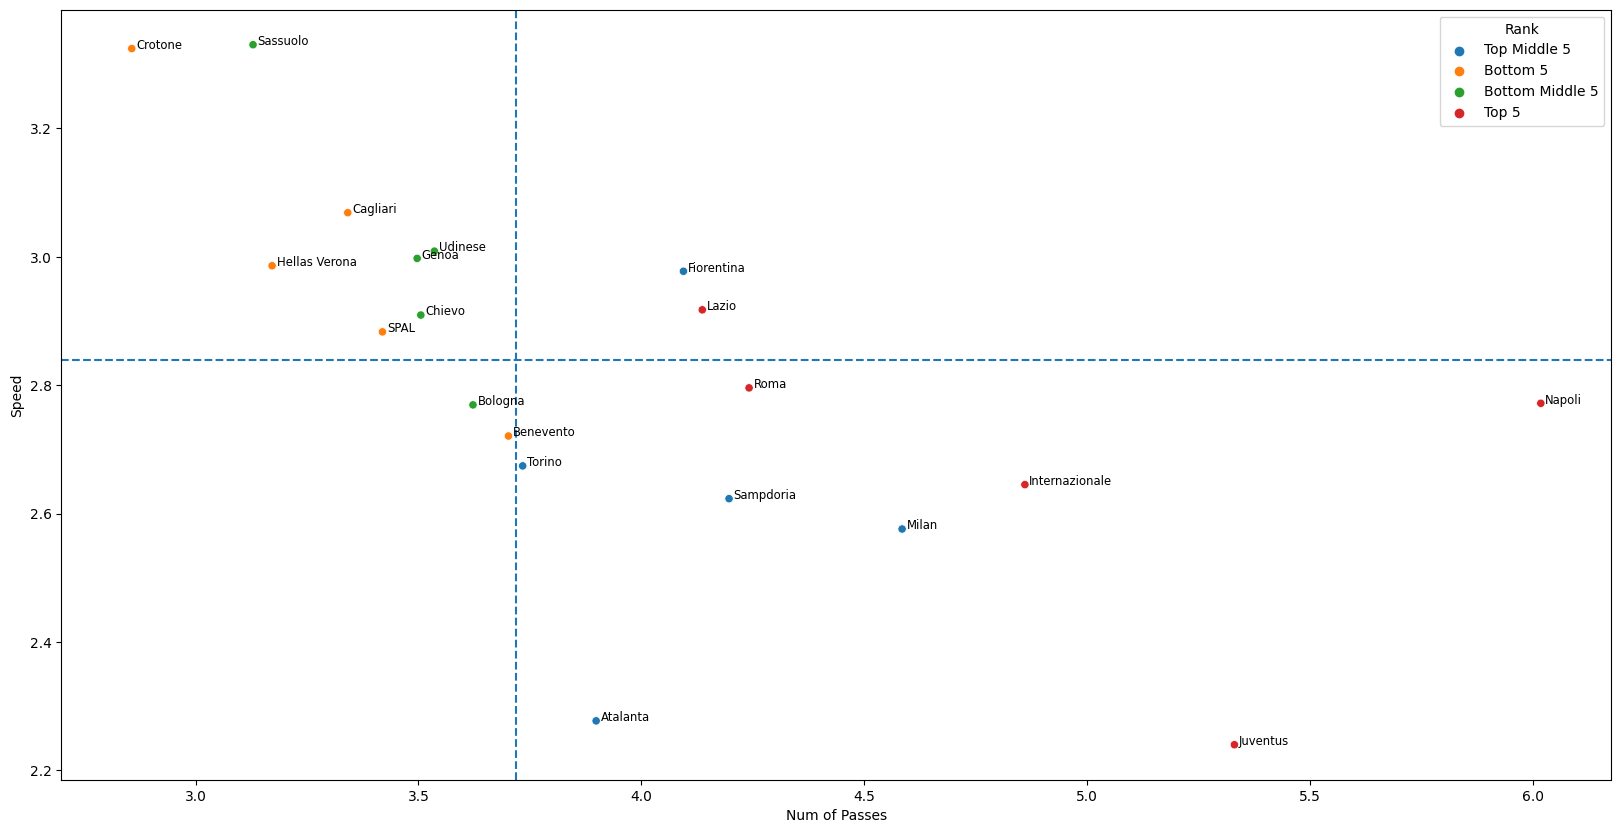

In [ ]:
# Visualizing that style
speed_med = team_style_grouped['Speed'].median()
pass_med = team_style_grouped['Num of Passes'].median()
ax = plt.figure(figsize=(20,10))
plt1 = sns.scatterplot(data = team_style_grouped, x='Num of Passes', y='Speed',hue = 'Rank')
plt1.axvline(x = pass_med, ymin = 0, ymax = 1,linestyle = "dashed")
plt1.axhline(y = speed_med, xmin = 0, xmax = 1,linestyle = "dashed")
for line in range(0,team_style_grouped.shape[0]):
     plt1.text(team_style_grouped['Num of Passes'][line]+0.01, team_style_grouped.Speed[line],
     team_style_grouped.index[line], horizontalalignment='left',
     size='small')

In [ ]:
# Encoding the Categorical columns
need_encode = ['First Event','Match Period','Side']
encoded_order = []
perform_encoded = perform.copy()
for i in need_encode:
  data = perform[i]
  le = LabelEncoder()
  le.fit(data)
  encoded_order.append(le.classes_)
  encoded_data = le.transform(data)
  perform_encoded[i] = encoded_data
perform_encoded.replace([np.inf, -np.inf], np.nan, inplace=True)
perform_encoded.dropna(inplace=True)

In [ ]:
# Displaying the enocded order of each column
for i in encoded_order:
  print(i)

['Duel' 'Free Kick' 'Goalkeeper leaving line' 'Interruption'
 'Others on the ball' 'Pass' 'Save attempt' 'Shot']
['1H' '2H']
['away' 'home']


In [ ]:
# Dividing the data in train and test subsets
y = perform_encoded.Successful
X = perform_encoded.drop(['Successful','Sequence','Name'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training the first model
cdt = tree.DecisionTreeClassifier()
cdt.fit(X_train, y_train)
y_pred = cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8074032841636516

In [ ]:
# Extracting the alphas to prune the tree to reduce complexcity
alphas = cdt.cost_complexity_pruning_path(X_train, y_train)['ccp_alphas']

In [ ]:
# Getting the best alpha that prunes that tree without sacrificing the accuracy
param_grid = [{
    'ccp_alpha': alphas}]
dt = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(dt, param_grid,scoring='accuracy',cv=3)
grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
score = grid_search.best_score_

In [ ]:
# Displaying the best parameters with its score
print(best_parameters)
print(score)

{'ccp_alpha': 0.00011238396915281606}
0.8329390792147456


In [ ]:
# Extracting the best model and testing it with test subset
best_cdt = grid_search.best_estimator_
y_pred = best_cdt.predict(X_test)
accuracy_score(y_test,y_pred)

0.8410102978012802

In [ ]:
# Saving the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = StringIO()
tree.export_graphviz(best_cdt, out_file=dot_data,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('/content/drive/MyDrive/thesis/Serie A/Serie_DT.png')

True

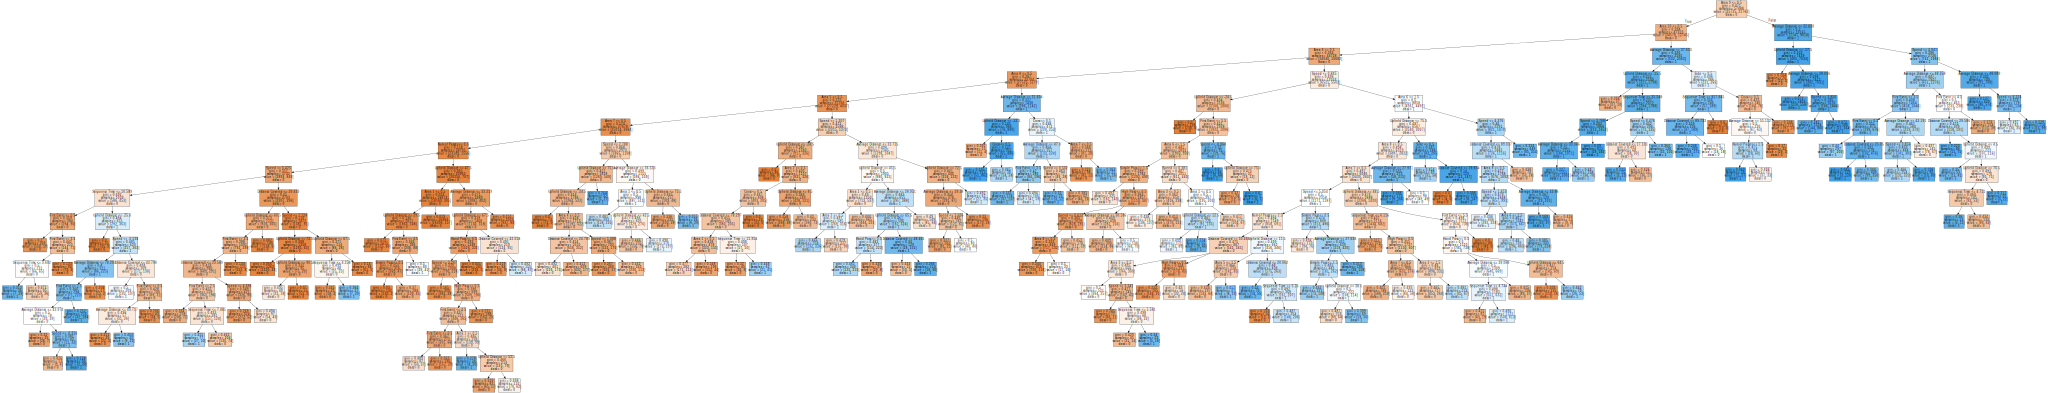

In [ ]:
# Visulaizing the Tree
features = [u'{}'.format(c) for c in X_train.columns]
classes = [u'{}'.format(c) for c in best_cdt.classes_]
dot_data = tree.export_graphviz(best_cdt, out_file=None,
                                feature_names=features,
                                class_names=classes,
                                filled=True)
graph = graphviz.Source(dot_data, format="png")
graph

# Question 2:	How can event sequence analysis identify the key players and positions that contribute most to a team's success in football, and what insights can be gained from this analysis?

In [19]:
# Transforming the teams data to H5 format
teams.to_hdf('Serie.h5', key='teams', mode='w')

# Transforming the players data to H5 format
players.to_hdf('Serie.h5', key='players', mode='a')

# Transforming the matches data to H5 format
matches.to_hdf('Serie.h5', key='matches', mode='a')

# Transforming the event data to H5 format grouped per
events_grouped_per_match = Serie.groupby('matchId', as_index=False)
for id, events_per_match in events_grouped_per_match:
  events_per_match.to_hdf('Serie.h5', key=f'events/match_{id}', mode='a')

# Converting the above data to SPAL format
convert_to_spadl('Serie.h5', 'spadl.h5')

<ipython-input-19-1ac277dd9cb7>:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['city', 'name', 'officialName', 'area', 'type'], dtype='object')]

  teams.to_hdf('Serie.h5', key='teams', mode='w')
<ipython-input-19-1ac277dd9cb7>:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['passportArea', 'firstName', 'middleName', 'lastName', 'currentTeamId',
       'birthDate', 'role', 'birthArea', 'foot', 'shortName',
       'currentNationalTeamId'],
      dtype='object')]

  players.to_hdf('Serie.h5', key='players', mode='a')
<ipython-input-19-1ac277dd9cb7>:8: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_va

...Inserting actiontypes
...Inserting bodyparts
...Inserting results
...Converting games
...Converting players
...Converting teams
...Generating player_games


100%|██████████| 380/380 [00:32<00:00, 11.78game/s]


...Converting events to actions


100%|██████████| 380/380 [03:52<00:00,  1.63game/s]


In [20]:
# Reading the required datasets from the SPAL format
games = pd.read_hdf('spadl.h5', key='games')
action_types = pd.read_hdf('spadl.h5', key='actiontypes')
body_parts = pd.read_hdf('spadl.h5', key='bodyparts')
results = pd.read_hdf('spadl.h5', key='results')

In [21]:
# Grouping all the necessary feature generators
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

# Retrieving the column names generated by the features
columns_features = features.feature_column_names(functions_features, nb_prev_actions=3)

# Grouping the target feature generators
functions_labels = [labels.scores,labels.concedes]
target_features = ['scores','concedes']

In [22]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Transforming the events to Game States
    gamestates = features.gamestates(actions, nb_prev_actions=3)
    gamestates = features.play_left_to_right(gamestates, game['home_team_id'])

# Extracting the features stated above and transforming it to H5 format
    features_df = pd.concat([function(gamestates) for function in functions_features], axis=1)
    features_df.to_hdf('features.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [23]:
# Extracting the necessary features
for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting Events data from SPAL format
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .reset_index(drop=True)
    )

# Extracting the labels stated above and transforming it to H5 format
    labels_df = pd.concat([function(actions) for function in functions_labels], axis=1)
    labels_df.to_hdf('labels.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [24]:
# Retreiving the relevant features and transforming them into a panda dataframe
features_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    features_per_game = pd.read_hdf('features.h5', key=f'game_{game_id}')
    features_list.append(features_per_game[columns_features])
features_df = pd.concat(features_list).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [25]:
# Visualizing the table to see how the features looks
features_df.head()

,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,type_take_on_a0,type_foul_a0,type_tackle_a0,...,end_dist_to_goal_a0,end_angle_to_goal_a0,end_dist_to_goal_a1,end_angle_to_goal_a1,end_dist_to_goal_a2,end_angle_to_goal_a2,team_1,team_2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,65.326898,0.083370,65.326898,0.083370,65.326898,0.083370,True,True,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,71.785214,0.398874,65.326898,0.083370,65.326898,0.083370,True,True,1.486822,1.486822
2,True,False,False,False,False,False,False,False,False,False,...,70.896344,0.212610,71.785214,0.398874,65.326898,0.083370,True,True,2.579799,4.066621
3,True,False,False,False,False,False,False,False,False,False,...,71.520000,0.349344,70.896344,0.212610,71.785214,0.398874,True,True,3.559624,6.139423
4,True,False,False,False,False,False,False,False,False,False,...,73.879635,0.101420,71.520000,0.349344,70.896344,0.212610,True,True,3.988235,7.547859


In [26]:
# Retreiving the relevant labels and transforming them into a panda dataframe
labels_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    labels_per_game = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    labels_list.append(labels_per_game[target_features])
labels_df = pd.concat(labels_list).reset_index(drop=True)

  0%|          | 0/380 [00:00<?, ?it/s]

In [27]:
# Visualizing the table to see how the features looks
labels_df.head()

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


In [30]:
print(len(labels_df))
print(len(labels_df))

496024
496024


In [29]:
# Training a classifier model for each label
models = {}
for label in target_features:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(features_df, labels_df[label])
    models[label] = model

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [31]:
# Using the trained models to transform the labels dataframe from true/false to probability of being true
probabilities_dict = {}
for label in target_features:
    model = models[label]
    probabilities = model.predict_proba(features_df)
    predictions = probabilities[:, 1]
    probabilities_dict[label] = pd.Series(predictions)
probabilities_df = pd.concat(probabilities_dict, axis=1)

In [32]:
# Extracting the game ids to have them with probabilties df and merging both into one
games_ids_list = []
for id, game in tqdm(games.iterrows(), total=len(games)):
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    games_ids_list.append(actions['game_id'])
game_ids_df = pd.concat(games_ids_list, axis=0).astype('int').reset_index(drop=True)
probabilities_df = pd.concat([probabilities_df, game_ids_df], axis=1)

  0%|          | 0/380 [00:00<?, ?it/s]

In [33]:
# Visualizing the table to see how the probabilities looks
probabilities_df.head()

,scores,concedes,game_id
0,0.000590,0.004135,2576335
1,0.001887,0.000626,2576335
2,0.003570,0.001198,2576335
3,0.005909,0.000913,2576335
4,0.007394,0.000486,2576335


In [34]:
# Grouping the probabilities by match
probabilities_per_game = probabilities_df.groupby('game_id')

# Saving them in H5 format
for game_id, probabilities in tqdm(probabilities_per_game):
    probabilities = probabilities.reset_index(drop=True)
    probabilities[target_features].to_hdf('probabilities.h5', key=f'game_{game_id}')

  0%|          | 0/380 [00:00<?, ?it/s]

In [35]:
# VAEP Calculations
players = pd.read_hdf('spadl.h5', key='players')
teams = pd.read_hdf('spadl.h5', key='teams')
all_per_game = []

for id, game in tqdm(games.iterrows(), total=len(games)):

# Extracting all required data to calculate VAEP
    game_id = game['game_id']
    actions = pd.read_hdf('spadl.h5', key=f'actions/game_{game_id}')
    actions = (actions
        .merge(action_types, how='left')
        .merge(results, how='left')
        .merge(body_parts, how='left')
        .merge(players, how='left')
        .merge(teams, how='left')
        .reset_index(drop=True)
    )
    probabilities_df = pd.read_hdf('probabilities.h5', key=f'game_{game_id}')
# Calculating VAEP
    values = value(actions, probabilities_df['scores'], probabilities_df['concedes'])

# Saving all to list
    all_df = pd.concat([actions, probabilities_df, values], axis=1)
    all_per_game.append(all_df)

# transforming all to pandas dataframe
vaep_rating = pd.concat(all_per_game)

  0%|          | 0/380 [00:00<?, ?it/s]

In [52]:
# Extracting minutes played by player
player_games = pd.read_hdf('spadl.h5', 'player_games')
player_games = player_games[player_games['game_id'].isin(games['game_id'])]
minutes_played = (player_games[['player_id', 'minutes_played']]
    .groupby('player_id')
    .sum()
    .reset_index()
)

In [53]:
# Aggregating the results and grouping them by player
players_ratings = (vaep_rating[['player_id', 'team_name', 'short_name', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'short_name'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'), vaep_mean=('vaep_value', 'mean'),)
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

# Adding column minutes played total per player
players_ratings = players_ratings.merge(minutes_played)

# Removing any player plaing less than 450 minutes (5 matches all league)
players_ratings = players_ratings[players_ratings['minutes_played'] > 450]

# Transforming VAEP to show players rating per match
players_ratings['vaep_per_match'] = players_ratings['vaep_sum'] * 90 / players_ratings['minutes_played']

# Average actions per plaer per match
players_ratings['actions_per_match'] = players_ratings['vaep_count'] * 90 / players_ratings['minutes_played']

# Sorting value by VAEP per match
players_ratings = players_ratings.sort_values('vaep_per_match', ascending=False)

In [54]:
# Adding two more columns that describes VAEP rating into success and fail actions
risk = pd.pivot_table(vaep_rating, values='vaep_value', index=['player_id', 'short_name', 'team_name'],
                                              columns=['result_name'], aggfunc=np.sum,
                                              fill_value=0)[['success', 'fail']]
risk = risk.reset_index()
risk = risk[0:-1]
risk = risk[['player_id','success','fail']]

# Merging these two columns with the players ratings
players_ratings = pd.merge(players_ratings, risk, on=['player_id'])

# Normalizing them to 90 minutes
players_ratings['success'] = players_ratings['success'] / players_ratings['minutes_played'] * 90
players_ratings['fail'] = players_ratings['fail'] / players_ratings['minutes_played'] * 90

In [55]:
# Visualizing the players ratings
players_ratings.head()

,player_id,team_name,short_name,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
0,25601.0,Benevento Calcio,C. Diabaté,177,4.598326,0.025979,713.032583,0.580407,22.341195,0.666932,-0.086312
1,21384.0,SS Lazio,C. Immobile,1196,17.242634,0.014417,2816.021721,0.551074,38.224137,0.792632,-0.239286
2,89186.0,Juventus FC,P. Dybala,1782,14.660555,0.008227,2451.475153,0.538227,65.421834,0.796810,-0.255560
3,40806.0,SS Lazio,Felipe Anderson,1022,7.087969,0.006935,1221.511377,0.522236,75.300158,0.826695,-0.300807
4,3484.0,SS Lazio,Luis Alberto,2292,15.855695,0.006918,2761.026859,0.516841,74.711334,0.734121,-0.208050


In [40]:
# Getting the top 4 leagues positions data
api=StatsBombLoader(getter="remote",creds=None)
english = api.games(competition_id=2,season_id=27)
italy = api.games(competition_id=12,season_id=27)
spain = api.games(competition_id=11,season_id=27)
german = api.games(competition_id=9,season_id=27)

/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


In [41]:
list_of_players = []
# Extracting the position of players in Premier League
unique_games = english['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass


# Extracting the position of players in Serie A
unique_games = italy['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

# Extracting the position of players in La Liga
unique_games = spain['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

# Extracting the position of players in Bundesliga
unique_games = german['game_id'].unique()
for game in unique_games:
  try:
    plrs = api.players(game_id=	game)
    extracted = plrs[['player_id','player_name','starting_position_name']]
    list_of_players.append(extracted)
  except:
    pass

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsbombpy/api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(
/usr/local/lib/pyth

In [56]:
# Putting all together
players_position = pd.concat(list_of_players)
players_position.head()

,player_id,player_name,starting_position_name
0,3049,Matt Ritchie,Right Midfield
1,3085,Glenn Murray,Substitute
2,3304,Harry Arter,Left Center Midfield
3,3341,Steve Cook,Left Center Back
4,3343,Dan Gosling,Right Center Midfield


In [57]:
# Determining the position the most played by each player
names = []
position = []
for name in players_position.player_name.unique():
  position_per_player = players_position[players_position['player_name']==name]
  names.append(name)
  if position_per_player.starting_position_name.value_counts().index[0] == 'Substitute':
    try:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[1])
    except:
      position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
  else:
    position.append(position_per_player.starting_position_name.value_counts().index.tolist()[0])
players_position = pd.DataFrame(list(zip(names, position)),columns =['player_name', 'position'])

In [58]:
# Function that matches names from 2 Dataframes
def fuzzy_merge(df_1, df_2, key1, key2, threshold=0, limit=1):
    s = df_2[key2].tolist()
    m = df_1[key1].apply(lambda x: process.extract(x, s, limit=limit,scorer=fuzz.token_set_ratio ))
    df_1['matches'] = m
    m2 = df_1['matches'].apply(lambda x: ', '.join([i[0] for i in x if i[1] >= threshold]))
    df_1['matches'] = m2
    return df_1

In [59]:
# Applying the function
players_ratings = fuzzy_merge(players_ratings, players_position, 'short_name', 'player_name')

In [60]:
players_ratings.matches.value_counts()

Luca Rigoni                      7
Emre Can                         5
Boško Janković                   5
Édgar Osvaldo Barreto Cáceres    5
Vid Belec                        4
                                ..
Stefano Mauri                    1
Armando Izzo                     1
Leonardo Bonucci                 1
Lorenzo Pellegrini               1
Marvin Matip                     1
Name: matches, Length: 362, dtype: int64

In [61]:
# Creating a new column for each player and his position
positions = []
for id,row in players_ratings.iterrows():
  player = row['matches']
  info = players_position[players_position['player_name']==player]
  position = info['position'].iloc[0]
  positions.append(position)
players_ratings['position'] = positions

In [65]:
# Understanding the number of players in each position
players_ratings.groupby(['position'])['position'].count()


position
CAM    19
CB     77
CDM    40
CF     61
GK     37
LB     41
LCM    38
LM     10
LW     23
RB     42
RCM    28
RM      9
RW     19
Sub    16
Name: position, dtype: int64

In [63]:
# Putting all CBs, RCBs and LCBs as CBs
players_ratings.replace('Left Center Back','Center Back', inplace = True)
players_ratings.replace('Right Center Back','Center Back', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Center Forward','Center Forward', inplace = True)
players_ratings.replace('Right Center Forward','Center Forward', inplace = True)

# Putting all CFs, RCFs and LCFs as CFs
players_ratings.replace('Left Defensive Midfield','Center Defensive Midfield', inplace = True)
players_ratings.replace('Right Defensive Midfield','Center Defensive Midfield', inplace = True)

# Putting all CAMs, RCAMs and LCAMs as CAMs
players_ratings.replace('Left Attacking Midfield','Center Attacking Midfield', inplace = True)
players_ratings.replace('Right Attacking Midfield','Center Attacking Midfield', inplace = True)

# Putting all RWBs to RBs and LWBs to LBs
players_ratings.replace('Left Wing Back','Left Back', inplace = True)
players_ratings.replace('Right Wing Back','Right Back', inplace = True)
players_ratings.replace('Center Midfield','Right Center Midfield', inplace = True)

In [64]:
# Abbreviating all positions
players_ratings.replace('Left Center Midfield','LCM', inplace = True)
players_ratings.replace('Center Attacking Midfield','CAM', inplace = True)
players_ratings.replace('Left Wing','LW', inplace = True)
players_ratings.replace('Right Midfield','RM', inplace = True)
players_ratings.replace('Right Wing','RW', inplace = True)
players_ratings.replace('Right Center Midfield','RCM', inplace = True)
players_ratings.replace('Substitute','Sub', inplace = True)
players_ratings.replace('Left Back','LB', inplace = True)
players_ratings.replace('Center Defensive Midfield','CDM', inplace = True)
players_ratings.replace('Left Midfield','LM', inplace = True)
players_ratings.replace('Center Forward','CF', inplace = True)
players_ratings.replace('Right Back','RB', inplace = True)
players_ratings.replace('Center Back','CB', inplace = True)
players_ratings.replace('Goalkeeper','GK', inplace = True)

In [66]:
# Aggregating and grouping by player position
positions_ranks = players_ratings.groupby(['position']).mean()

<ipython-input-66-ea2832b3073a>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks = players_ratings.groupby(['position']).mean()


In [67]:
# Seeing the table
positions_ranks

,player_id,vaep_count,vaep_sum,vaep_mean,minutes_played,vaep_per_match,actions_per_match,success,fail
position,,,,,,,,,
CAM,70596.789474,1091.789474,4.613089,0.003375,1848.150860,0.199237,48.474934,0.310157,-0.108459
CB,92408.298701,1207.493506,2.955964,0.002121,1916.743354,0.129518,55.159842,0.187649,-0.056910
CDM,70088.875000,1129.150000,3.430657,0.003311,1731.884617,0.177315,58.213338,0.254785,-0.074779
CF,46205.803279,642.032787,2.463358,0.003334,1654.288860,0.110652,34.732922,0.249817,-0.137172
GK,100723.378378,921.162162,2.334311,0.002402,2051.230701,0.107157,42.097588,0.168727,-0.060469
LB,132129.048780,1178.000000,3.214512,0.002331,1707.050856,0.146649,59.627764,0.232601,-0.083890
LCM,62021.631579,1195.342105,3.322343,0.003019,2094.104979,0.143939,50.224157,0.237127,-0.090672
LM,141137.000000,1390.700000,4.854079,0.003317,2030.822556,0.204347,59.310700,0.315208,-0.109134
LW,51999.391304,1357.521739,4.417740,0.004355,2095.688784,0.197644,54.090894,0.337785,-0.138245


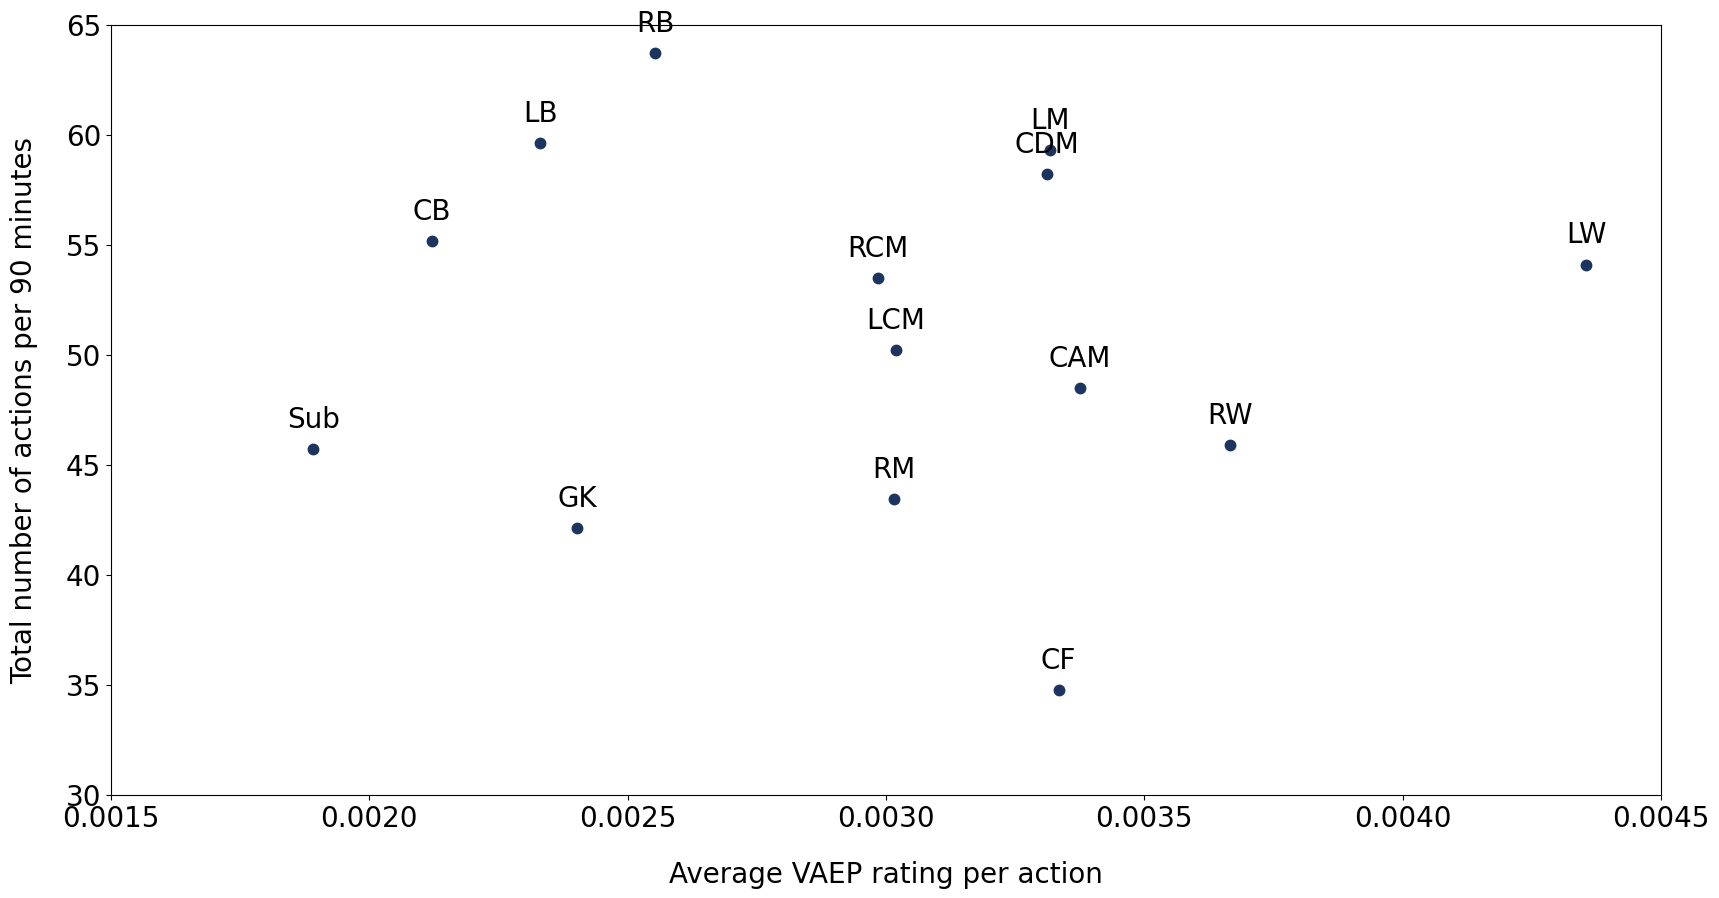

In [71]:
# Analyzing Quantity vs Quality
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['vaep_mean'])
y = list(positions_ranks['actions_per_match'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i] + 1), fontsize=20, horizontalalignment='center')


plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.0015, 0.0045)
plt.ylim(30, 65)
plt.xlabel('Average VAEP rating per action', labelpad=20, fontsize=20)
plt.ylabel('Total number of actions per 90 minutes', labelpad=20, fontsize=20)
plt.show()

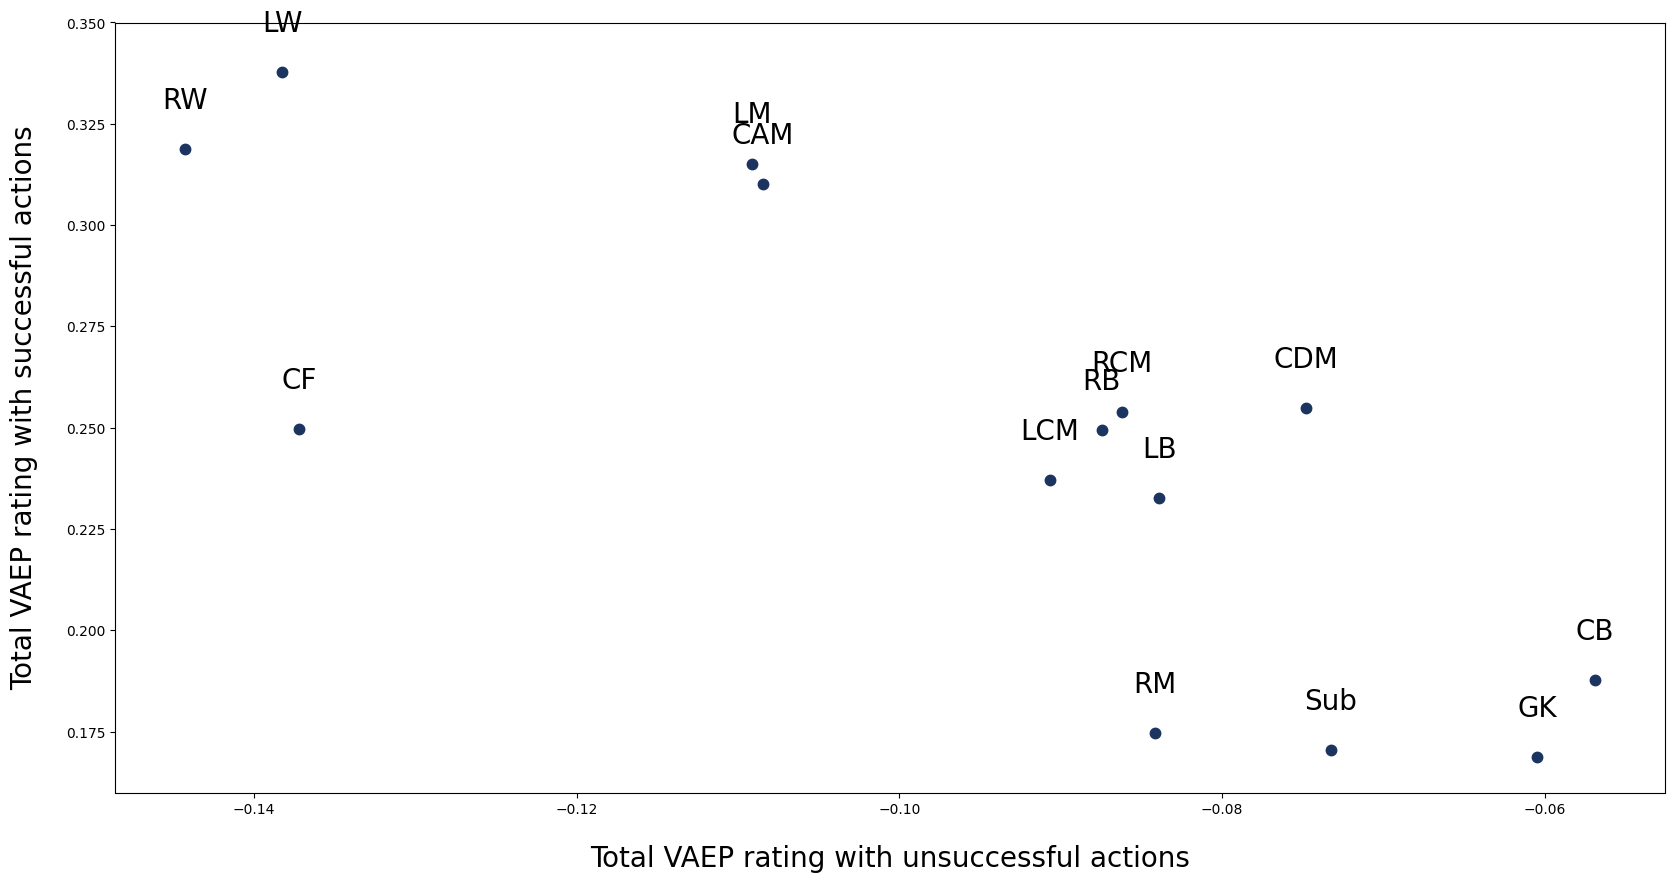

In [75]:
# Analyzing Risk taken by position
positions_ranks = positions_ranks.sort_values('vaep_per_match', ascending=False)
plt.figure(figsize=(20, 10))
x = list(positions_ranks['fail'])
y = list(positions_ranks['success'])
plt.plot(x, y, '.', c='#1C3460', markersize=15)

names = positions_ranks.index.values.tolist()
for i, txt in enumerate(names):
    plt.annotate(txt, (x[i], y[i]+ 0.01), fontsize=20, horizontalalignment='center')
plt.ylim(0.16,0.35)
plt.xlabel('Total VAEP rating with unsuccessful actions', labelpad=20, fontsize=20)
plt.ylabel('Total VAEP rating with successful actions', labelpad=20, fontsize=20)
plt.show()

In [76]:
# Getting Best 3 position by Club
positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])
positions_ranks_by_club.groupby(level=0).head(3)

<ipython-input-76-290b12a981b2>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  positions_ranks_by_club = players_ratings.groupby(['team_name','position']).mean().sort_values(['team_name', 'vaep_per_match'], ascending=[True, False])


player_id   vaep_count  \
team_name                              position                               
AC Chievo Verona                       LW         20468.000000   542.000000   
                                       RW         99511.000000   253.000000   
                                       RB         21607.000000  2336.000000   
AC Milan                               LB         11063.000000  2211.000000   
                                       LM        107159.333333  2015.333333   
                                       RB        138709.000000  1179.500000   
ACF Fiorentina                         RCM        23960.500000  2207.000000   
                                       CAM       145088.500000   784.000000   
                                       RB        122539.500000   996.500000   
AS Roma                                CDM        22921.500000  1226.500000   
                                       LB        111263.000000  2367.500000   
                                       LCM       123675.000000  1411.666667   
Atalanta Bergamasca Calcio             CAM        20820.000000  1697.000000   
                                       RW        393292.500000   651.000000   
                                       CDM        35798.333333  1833.333333   
Benevento Calcio                       CDM        34908.666667   542.333333   
                                       RW         21322.000000   523.000000   
                                       LM        255670.000000   526.000000   
Bologna FC 1909                        CAM        21123.000000  1824.000000   
                                       RCM       295273.000000   931.000000   
                                       LCM        55398.500000  1855.500000   
Cagliari Calcio                        LB        402898.000000   530.000000   
                                       RB         68321.500000  1232.000000   
                                       RM        189561.500000  1336.000000   
FC Crotone                             CAM        21655.000000  1387.000000   
                                       CF         10634.500000   820.500000   
                                       CDM        38147.000000  1181.666667   
FC Internazionale Milano               CF        206314.000000   709.000000   
                                       LCM        70965.000000   493.000000   
                                       CDM       116349.000000  1955.000000   
Genoa CFC                              LB         48879.000000  1434.333333   
                                       CB         27495.666667  1296.000000   
                                       RCM        35900.000000   784.500000   
Hellas Verona FC                       CB         13035.000000   734.000000   
                                       LCM        21006.333333   834.666667   
                                       GK         23427.000000   886.000000   
Juventus FC                            LM        105334.000000  1471.000000   
                                       RCM        15017.000000  1375.666667   
                                       CF         35817.333333  1386.333333   
SS Lazio                               RW         40806.000000  1022.000000   
                                       CAM         3484.000000  2292.000000   
                                       CDM         7965.000000  2509.000000   
SSC Napoli                             CF         99452.000000   200.000000   
                                       LB         23978.000000  1788.500000   
                                       CDM       374013.000000   808.000000   
Società Polisportiva Ars et Labor 2013 LW         23386.000000   310.000000   
                                       CDM        20448.000000  2090.000000   
                                       GK         20911.000000  1476.000000   
Torino FC                              LW          8148.000000  1859.000000   
                        